# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [0]:
 # Basic imports.
import os
import time
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [2]:
# Setting predefined arguments.
args = {
    'epoch_num': 50,      # Number of epochs.
    'lr': 5e-4,           # Learning rate.
    'weight_decay': 1e-5, # L2 penalty.
    'num_workers': 3,     # Number of workers on data loader.
    'batch_size': 100,    # Mini-batch size.
    'print_freq': 1,      # Printing frequency.
    'lambda_var': 1.0,    # Variational multiplier in loss.
    'num_gauss': 20,      # Number of gaussians in bottleneck of VAE.
    'num_samples': 8,     # Number of samples to be generated in evaluation.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


# Carregando o  MNIST

In [3]:
# Root directory for the dataset (to be downloaded).
root = './'

# Transformations over the dataset.
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

# Setting datasets and dataloaders.
train_set = datasets.MNIST(root,
                           train=True,
                           download=True,
                           transform=data_transforms)
test_set = datasets.MNIST(root,
                          train=False,
                          download=False,
                          transform=data_transforms)

# Setting dataloaders.
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

# Printing training and testing dataset sizes.
print('Size of training set: ' + str(len(train_set)) + ' samples')
print('Size of test set: ' + str(len(test_set)) + ' samples')


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!
Size of training set: 60000 samples
Size of test set: 10000 samples


# AutoEncoder Variacional

Idealmente codificações compactas de dados redundantes (i.e. imagens) deveriam produzir representações latentes que fossem independentes uma da outra num nível semântico. Ou seja, cada bin num feature map latente $z$ de um autoencoder deveria codificar o máximo de informação possível (i.e. linhas verticais que compõem um '1', '7' ou '9'; ou círculos que compõem um '6', '8' ou '0') para a reconstrução dos dígitos do MNIST, por exemplo. A [inferência variacional](https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf) provém uma forma mais simples de computarmos o Maximum a Posteriori (MAP) de distribuições estatísticas complexas como as que estamos lidando.

![VAE Features](https://www.dropbox.com/s/fkvdn69tkh7tm1p/vae_gaussian.png?dl=1)

Se tivermos controle sobre representações latentes em $z$ que codificam features de algo nível semântico, podemos utilizar o Decoder de um AE para geração de novas amostras. Usando o Encoder de um AE tradicional, conseguimos partir do vetor de entrada $x$ e chegar no vetor latente $z \sim q(z ∣ x)$. Porém, como não temos controle sobre a distribuição $q$, não é possível fazer o caminho inverso, ou seja, a partir de $z$ modelar $x \sim p(x | z)$. Essa é a motivação para um Variational AutoEncoder (VAE).

![VAE x->z](https://www.dropbox.com/s/o8daaskdrhfav7r/VAE_Enc.png?dl=1)

![VAE z->x](https://www.dropbox.com/s/wqi8nsak84i11mi/VAE_Dec.png?dl=1)

Para podermos ter um controle maior sobre distribuição de cada bin de $z$, adicionamos uma "regularização" $\mathcal{L}_{KL}(\mu, \sigma)$ à loss de regressão $\mathcal{L}_{r}(x, \hat{x})$ de um AE tradicional. Percebe-se que $\mu$ e $\sigma$ devem codificar a média e o desvio padrão de distribuições gaussianas multivariadas, o que permite realizarmos uma amostragem dessa distribuição. Não podemos, porém, backpropagar de nós na nossa rede que realizem amostragem de uma distribuição. Portanto, precisamos do truque da reparametrização mostrado abaixo para backpropagarmos apenas por $\mu$ e $\sigma$, mas não por $\epsilon$.

![Reparametrization](https://jaan.io/images/reparametrization.png)

Assim, a arquitetura final de um VAE segue o esquema a seguir composto no bottleneck por um vetor $\mu$, um vetor $\sigma$ e um vetor $\epsilon$, que formam a representação latente $z = \mu + \sigma * \epsilon$.

![VAE training](https://www.dropbox.com/s/719vkfnfsobimmd/VAE_training.png?dl=1)

A ideia é que cada gaussiana codifique uma característica de alto nível nos dados, permitindo que utilizemos o modelo generativo do VAE para, de fato, gerar amostras novas verossímeis no domínio dos dados de treino.

![VAE gif](https://media.giphy.com/media/26ufgj5LH3YKO1Zlu/giphy.gif)

Para entender mais sobre "disentangled representations", ler o paper original do [VAE](https://arxiv.org/abs/1312.6114), o [$\beta$-VAE](https://openreview.net/references/pdf?id=Sy2fzU9gl) e o paper que propõe as [InfoGANs](https://arxiv.org/pdf/1606.03657.pdf):

# Definindo a arquitetura

In [4]:
# AutoEncoder implementation.
class VariationalAutoEncoder(nn.Module):
    
    def __init__(self, n_gaus):

        super(VariationalAutoEncoder, self).__init__()
        
        self.n_gaus = n_gaus
        
        # Encoder.
        self.enc_1 = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
        )
        self.enc_2 = nn.Sequential(
            nn.Linear(400, 200),
            nn.ReLU(),
        )
        # Layers mu and sigma.
        self.enc_mu = nn.Linear(200, n_gaus) # Mean vector.
        self.enc_sigma = nn.Linear(200, n_gaus) # Std vector.
        
        # Decoder.
        self.decoder = nn.Sequential(
            nn.Linear(n_gaus, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )
        
        self.initialize_weights()
        
    # Encoding function.
    def encode(self, x):
        
        out_1 = self.enc_1(x)
        out_2 = self.enc_2(out_1)
        
        out_mu = self.enc_mu(out_2) # Mean vector.
        out_sigma = self.enc_sigma(out_2) # Std vector.
        
        return out_mu, out_sigma
        
    # Decoding function.
    def decode(self, z):
        
        out = self.decoder(z)
        
        return out
               
    # Reparametrization function. 
    def reparameterize(self, mu, logvar):
        
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + (eps * std)
    
    # Function for randomly initializing weights.
    def initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        
        mu, logvar = self.encode(x)
        
        z = self.reparameterize(mu, logvar)
        
        dec = self.decode(z)
        
        return dec, mu, logvar

# Instantiating architecture.
net = VariationalAutoEncoder(args['num_gauss']).to(args['device'])

# Printing architecture.
print(net)

VariationalAutoEncoder(
  (enc_1): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
  )
  (enc_2): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
  )
  (enc_mu): Linear(in_features=200, out_features=20, bias=True)
  (enc_sigma): Linear(in_features=200, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=400, bias=True)
    (3): ReLU()
    (4): Linear(in_features=400, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


# Definindo o otimizador

In [0]:
optimizer = optim.Adam(net.parameters(),
                       lr=args['lr'],
                       weight_decay=args['weight_decay'])

# Definindo a loss

In [0]:
# Reconstruction + KL losses summed over all elements and batch.
def variational_loss(recon_x, x, mu, logvar):
    
    # Reconstruction loss using BCE
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL Divergence loss.
    # See Appendix B from VAE paper:
    #     https://arxiv.org/pdf/1312.6114.pdf.
    # See Pytorch's implementation of VAEs:
    #     https://github.com/pytorch/examples/blob/master/vae/main.py.
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE, KLD

# Criando funções para Treino e Teste

In [0]:
# Training procedure.
def train(train_loader, net, optimizer, epoch):

    tic = time.time()
    
    # Setting network for training mode.
    net.train()

    # Lists for losses and metrics.
    train_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data
        
        # Casting to cuda variables and reshaping.
        inps = inps.view(inps.size(0), -1).to(args['device'])
        
        # Clears the gradients of optimizer.
        optimizer.zero_grad()

        # Forwarding.
        outs, mu, logvar = net(inps)

        # Computing total loss.
        loss_bce, loss_kld = variational_loss(outs, inps, mu, logvar)
        
        loss = loss_bce + args['lambda_var'] * loss_kld

        # Computing backpropagation.
        loss.backward()
        optimizer.step()
        
        # Updating lists.
        train_loss.append((loss_bce.data.item(),
                           args['lambda_var'] * loss_kld.data.item(),
                           loss.data.item()))
    
    toc = time.time()
    
    train_loss = np.asarray(train_loss)
    
    # Printing training epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [train bce loss %.4f +/- %.4f], [train kld loss %.4f +/- %.4f], [training time %.2f]' % (
        epoch, train_loss[:,0].mean(), train_loss[:,0].std(), train_loss[:,1].mean(), train_loss[:,1].std(), (toc - tic)))
    print('-------------------------------------------------------------------')
    

In [0]:
# Testing procedure.
def test(test_loader, net, epoch):

    tic = time.time()
    
    # Setting network for evaluation mode.
    net.eval()

    # Lists for losses and metrics.
    test_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(test_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data

        # Casting to cuda variables and reshaping.
        inps = inps.view(inps.size(0), -1).to(args['device'])

        # Forwarding.
        outs, mu, logvar = net(inps)

        # Computing loss.
        loss_bce, loss_kld = variational_loss(outs, inps, mu, logvar)
        
        loss = loss_bce + args['lambda_var'] * loss_kld
        
        # Updating lists.
        test_loss.append((loss_bce.data.item(),
                          args['lambda_var'] * loss_kld.data.item(),
                          loss.data.item()))
        
        if i == 0 and epoch % args['print_freq'] == 0:
            
            fig, ax = plt.subplots(2, 8, figsize=(16, 4))
        
        if i < 8 and epoch % args['print_freq'] == 0:
            
            ax[0, i].imshow(inps.view(inps.size(0), 28, 28)[0].detach().cpu().numpy())
            ax[0, i].set_yticks([])
            ax[0, i].set_xticks([])
            ax[0, i].set_title('Image ' + str(i + 1))
            
            ax[1, i].imshow(outs.view(inps.size(0), 28, 28)[0].detach().cpu().numpy())
            ax[1, i].set_yticks([])
            ax[1, i].set_xticks([])
            ax[1, i].set_title('Reconstructed ' + str(i + 1))
            
        if i == 8 and epoch % args['print_freq'] == 0:
            
            plt.show()
    
    toc = time.time()
    
    test_loss = np.asarray(test_loss)
    
    # Printing training epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [test bce loss %.4f +/- %.4f], [test kld loss %.4f +/- %.4f], [testing time %.2f]' % (
        epoch, test_loss[:,0].mean(), test_loss[:,0].std(), test_loss[:,1].mean(), test_loss[:,1].std(), (toc - tic)))
    print('-------------------------------------------------------------------')

In [0]:
# Evaluation procedure for sample generation.
def evaluate(net, n_samples, n_gauss):

    # Setting network for evaluation mode.
    net.eval()
    
    # Plotting new samples generated from VAE.
    fig, ax = plt.subplots(1, n_samples, figsize=(n_samples*2, 2))

    # Iterating over batches.
    for i in range(n_samples):
        
        # Sampling from Gaussian.
        sample = torch.randn(1, n_gauss).to(args['device'])
        
        # Forwarding through Decoder.
        sample = net.decode(sample).detach().cpu().view(28, 28).numpy()
        
        ax[i].imshow(sample)
        ax[i].set_yticks([])
        ax[i].set_xticks([])
        ax[i].set_title('New Sample ' + str(i + 1))
        
    plt.show()

# Iterando sobre epochs

-------------------------------------------------------------------
[epoch 1], [train bce loss 21011.8779 +/- 6088.0168], [train kld loss 340.8533 +/- 454.0446], [training time 8.19]
-------------------------------------------------------------------


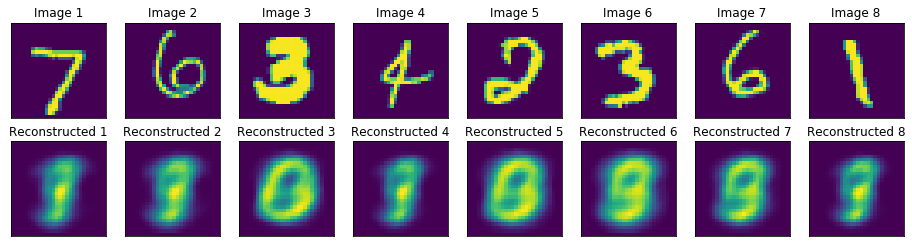

-------------------------------------------------------------------
[epoch 1], [test bce loss 18802.4026 +/- 982.7915], [test kld loss 339.4408 +/- 65.9965], [testing time 1.64]
-------------------------------------------------------------------


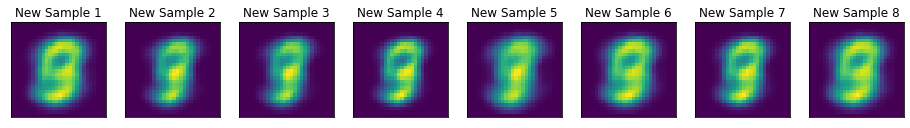

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 2], [train bce loss 17855.2062 +/- 736.8665], [train kld loss 434.3426 +/- 61.7440], [training time 8.05]
-------------------------------------------------------------------


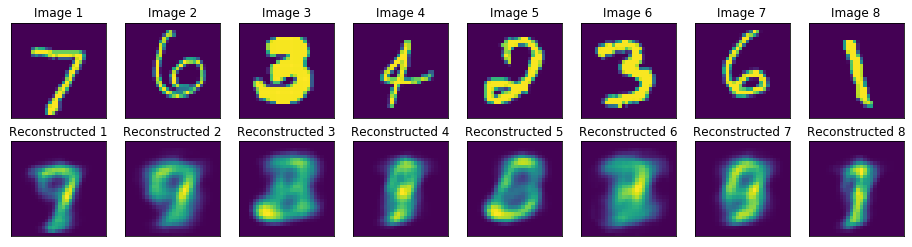

-------------------------------------------------------------------
[epoch 2], [test bce loss 16870.0549 +/- 873.1503], [test kld loss 536.0219 +/- 67.4984], [testing time 1.65]
-------------------------------------------------------------------


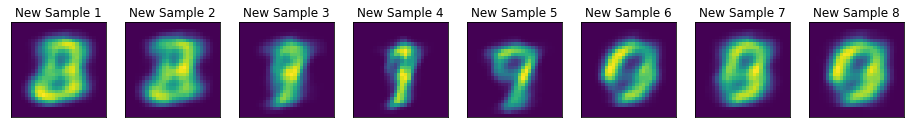

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 3], [train bce loss 16072.7195 +/- 656.6488], [train kld loss 613.8046 +/- 43.9243], [training time 7.66]
-------------------------------------------------------------------


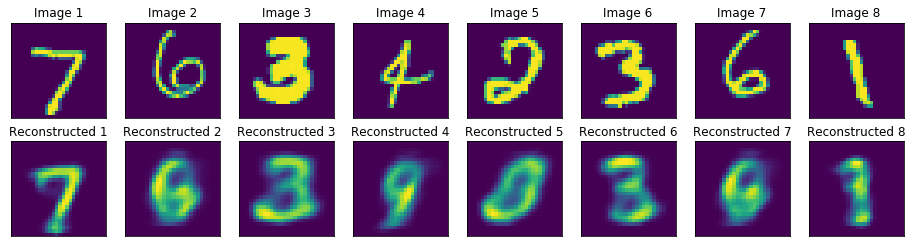

-------------------------------------------------------------------
[epoch 3], [test bce loss 15153.7865 +/- 702.2712], [test kld loss 727.2499 +/- 86.1329], [testing time 1.62]
-------------------------------------------------------------------


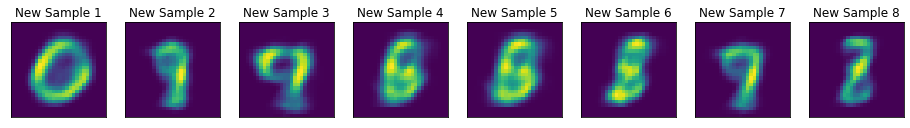

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 4], [train bce loss 14189.5920 +/- 727.0916], [train kld loss 879.7344 +/- 88.5884], [training time 7.97]
-------------------------------------------------------------------


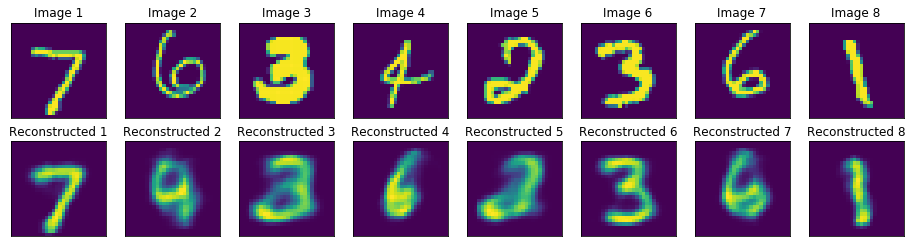

-------------------------------------------------------------------
[epoch 4], [test bce loss 13260.7668 +/- 661.3326], [test kld loss 983.1323 +/- 85.1903], [testing time 1.72]
-------------------------------------------------------------------


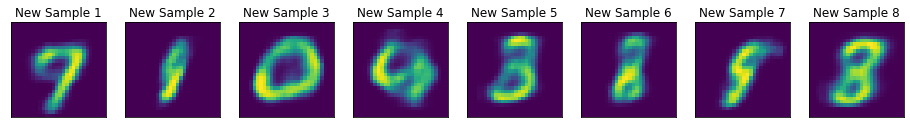

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 5], [train bce loss 12827.8578 +/- 501.0420], [train kld loss 1041.3370 +/- 49.5601], [training time 7.91]
-------------------------------------------------------------------


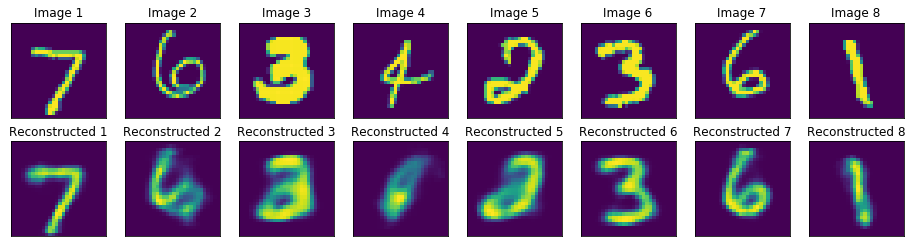

-------------------------------------------------------------------
[epoch 5], [test bce loss 12126.6813 +/- 610.5752], [test kld loss 1120.7723 +/- 80.0805], [testing time 1.83]
-------------------------------------------------------------------


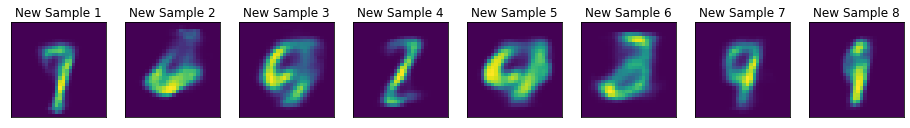

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 6], [train bce loss 11884.1419 +/- 441.0556], [train kld loss 1163.2218 +/- 30.0155], [training time 7.81]
-------------------------------------------------------------------


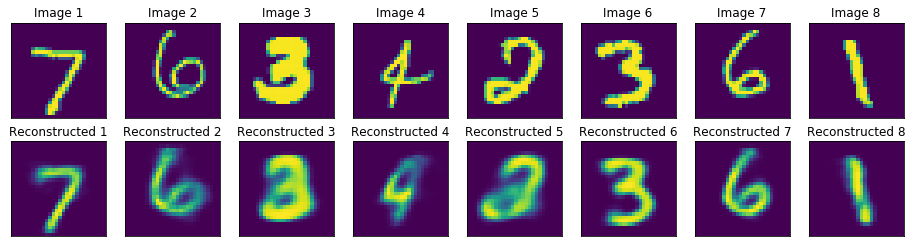

-------------------------------------------------------------------
[epoch 6], [test bce loss 11524.2829 +/- 591.6868], [test kld loss 1187.4747 +/- 63.5841], [testing time 1.62]
-------------------------------------------------------------------


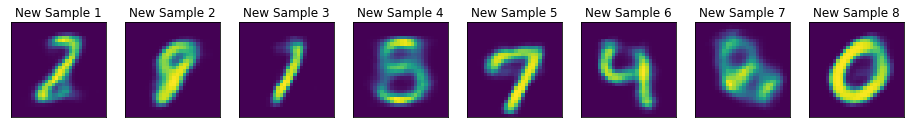

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 7], [train bce loss 11430.2330 +/- 427.0121], [train kld loss 1227.9364 +/- 34.6555], [training time 7.99]
-------------------------------------------------------------------


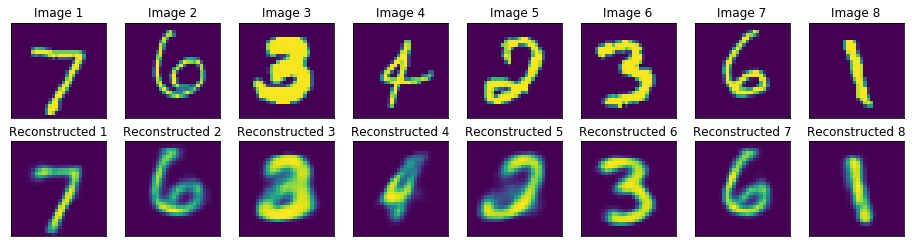

-------------------------------------------------------------------
[epoch 7], [test bce loss 11095.9075 +/- 592.7646], [test kld loss 1299.5051 +/- 63.5897], [testing time 1.89]
-------------------------------------------------------------------


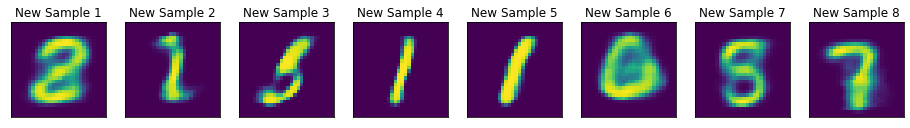

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 8], [train bce loss 11054.7799 +/- 392.1041], [train kld loss 1297.7464 +/- 28.5133], [training time 8.15]
-------------------------------------------------------------------


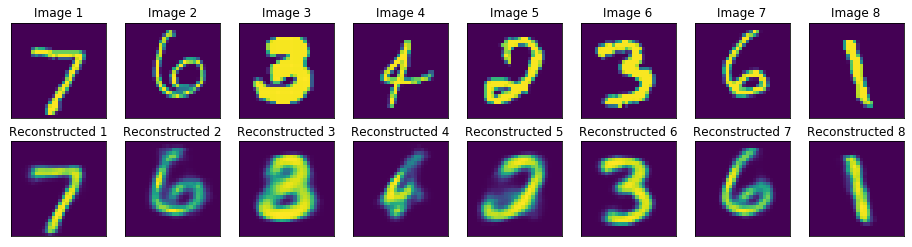

-------------------------------------------------------------------
[epoch 8], [test bce loss 10845.4479 +/- 589.3672], [test kld loss 1307.7046 +/- 59.7580], [testing time 1.66]
-------------------------------------------------------------------


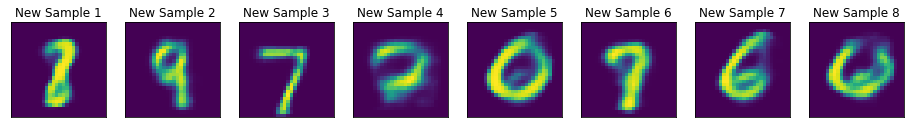

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 9], [train bce loss 10771.5132 +/- 379.9953], [train kld loss 1341.6871 +/- 26.3025], [training time 8.27]
-------------------------------------------------------------------


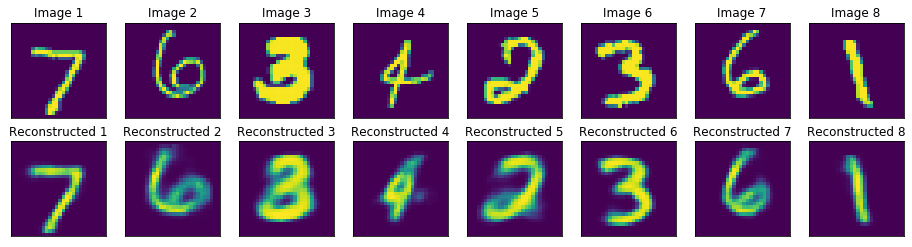

-------------------------------------------------------------------
[epoch 9], [test bce loss 10554.2863 +/- 578.4931], [test kld loss 1351.1049 +/- 53.5048], [testing time 1.96]
-------------------------------------------------------------------


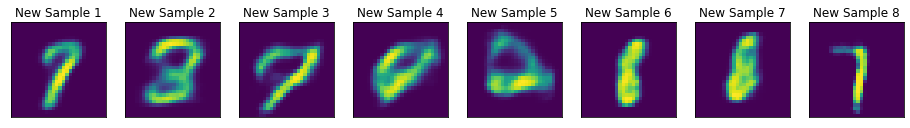

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 10], [train bce loss 10531.8124 +/- 356.2173], [train kld loss 1364.9353 +/- 27.0487], [training time 7.83]
-------------------------------------------------------------------


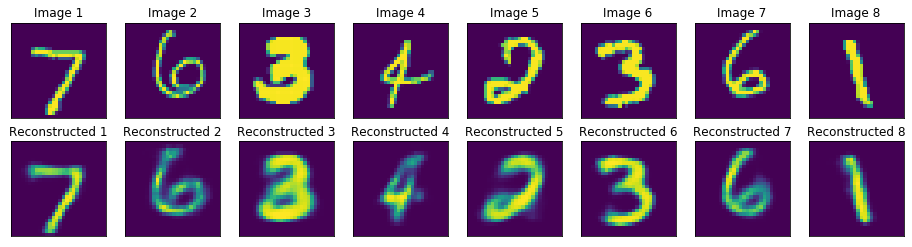

-------------------------------------------------------------------
[epoch 10], [test bce loss 10387.2227 +/- 574.4086], [test kld loss 1379.7907 +/- 49.0099], [testing time 1.64]
-------------------------------------------------------------------


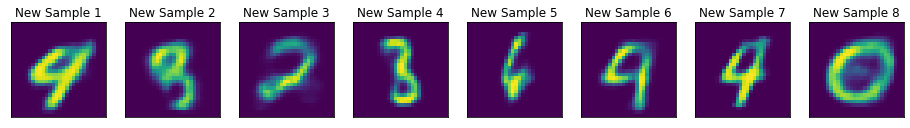

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 11], [train bce loss 10362.7511 +/- 366.0255], [train kld loss 1386.5229 +/- 26.8402], [training time 8.24]
-------------------------------------------------------------------


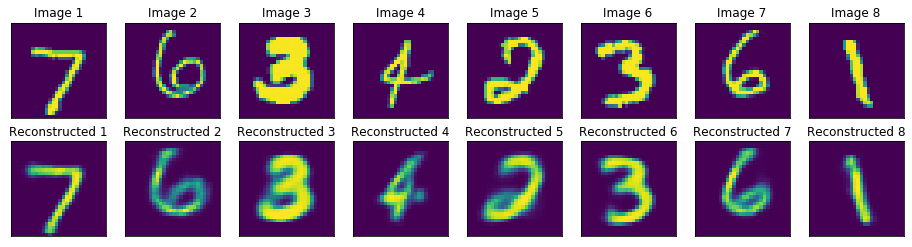

-------------------------------------------------------------------
[epoch 11], [test bce loss 10218.5872 +/- 575.3310], [test kld loss 1393.2771 +/- 49.6937], [testing time 1.73]
-------------------------------------------------------------------


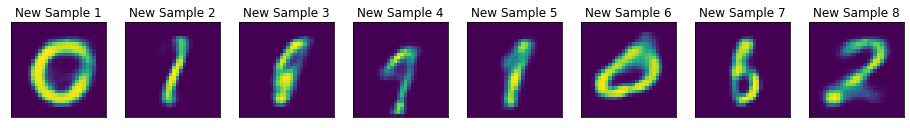

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 12], [train bce loss 10230.5268 +/- 366.1204], [train kld loss 1400.2724 +/- 24.0473], [training time 7.91]
-------------------------------------------------------------------


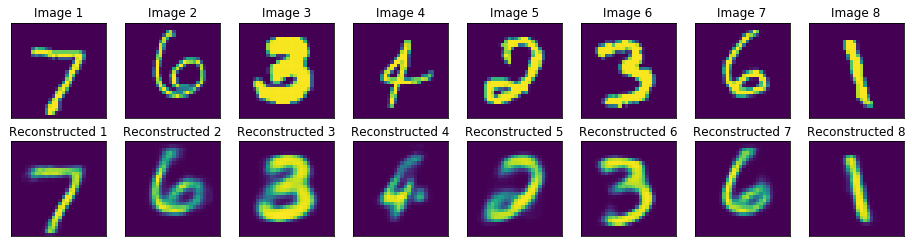

-------------------------------------------------------------------
[epoch 12], [test bce loss 10104.3026 +/- 577.9431], [test kld loss 1440.2540 +/- 48.7001], [testing time 1.69]
-------------------------------------------------------------------


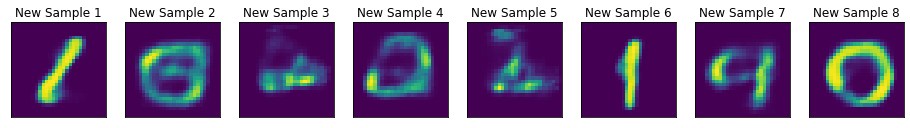

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 13], [train bce loss 10125.3306 +/- 356.0115], [train kld loss 1412.4589 +/- 26.8398], [training time 7.83]
-------------------------------------------------------------------


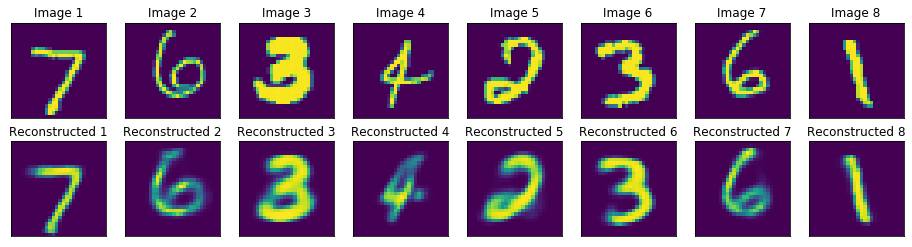

-------------------------------------------------------------------
[epoch 13], [test bce loss 10056.6432 +/- 575.7810], [test kld loss 1417.9512 +/- 46.7402], [testing time 1.70]
-------------------------------------------------------------------


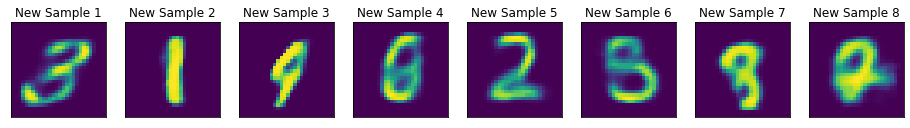

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 14], [train bce loss 10031.2764 +/- 341.5504], [train kld loss 1423.5074 +/- 24.5094], [training time 7.63]
-------------------------------------------------------------------


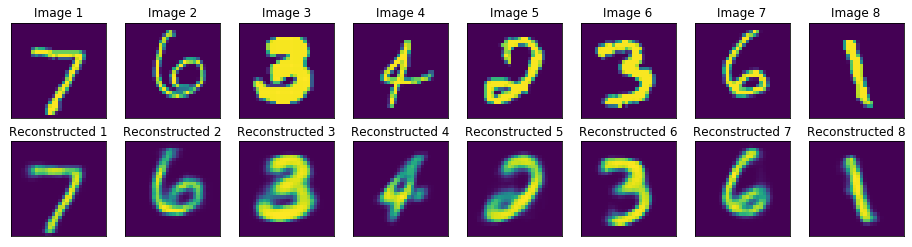

-------------------------------------------------------------------
[epoch 14], [test bce loss 9975.0326 +/- 583.1523], [test kld loss 1418.9642 +/- 44.7014], [testing time 1.73]
-------------------------------------------------------------------


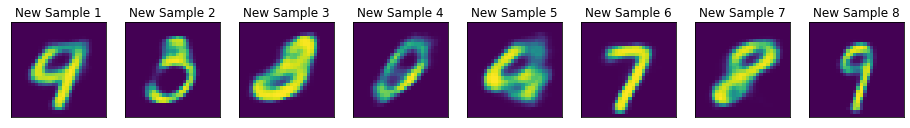

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 15], [train bce loss 9931.0253 +/- 362.0794], [train kld loss 1446.7987 +/- 25.8268], [training time 7.98]
-------------------------------------------------------------------


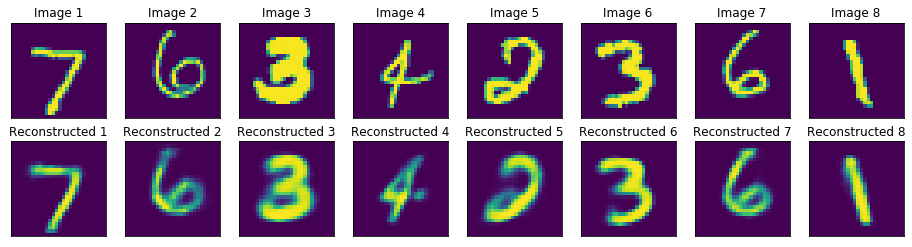

-------------------------------------------------------------------
[epoch 15], [test bce loss 9865.5872 +/- 591.3540], [test kld loss 1442.0631 +/- 41.3712], [testing time 1.69]
-------------------------------------------------------------------


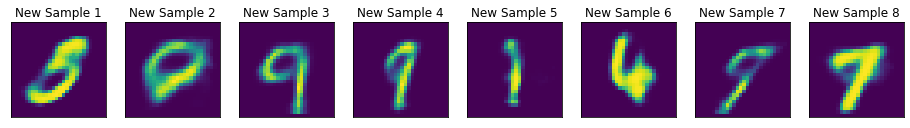

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 16], [train bce loss 9820.5199 +/- 341.1624], [train kld loss 1473.4458 +/- 27.1774], [training time 7.91]
-------------------------------------------------------------------


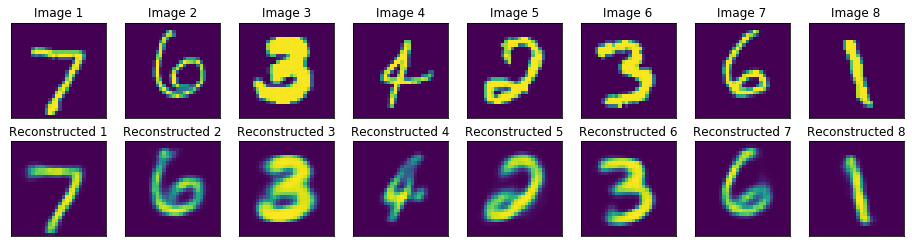

-------------------------------------------------------------------
[epoch 16], [test bce loss 9778.6542 +/- 579.5152], [test kld loss 1468.1035 +/- 45.9196], [testing time 1.73]
-------------------------------------------------------------------


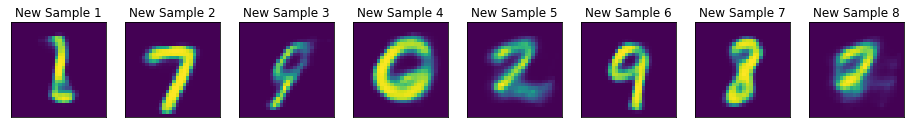

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 17], [train bce loss 9732.1270 +/- 355.3148], [train kld loss 1492.4373 +/- 26.5054], [training time 7.91]
-------------------------------------------------------------------


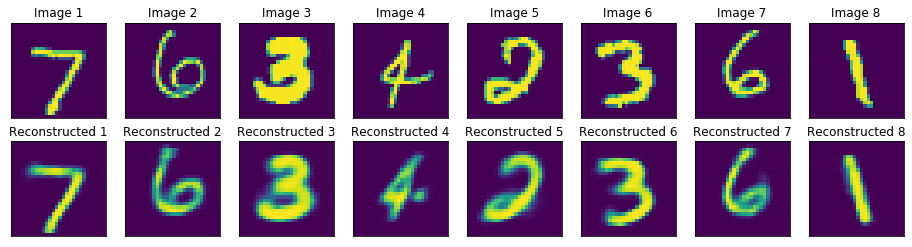

-------------------------------------------------------------------
[epoch 17], [test bce loss 9696.4449 +/- 581.5448], [test kld loss 1487.2041 +/- 41.4311], [testing time 1.71]
-------------------------------------------------------------------


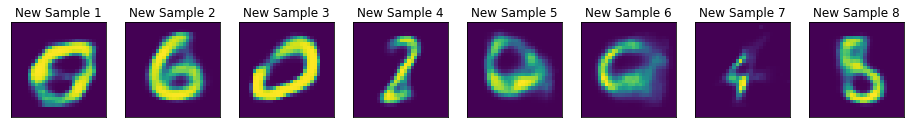

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 18], [train bce loss 9655.7264 +/- 342.3699], [train kld loss 1507.0414 +/- 28.3256], [training time 8.24]
-------------------------------------------------------------------


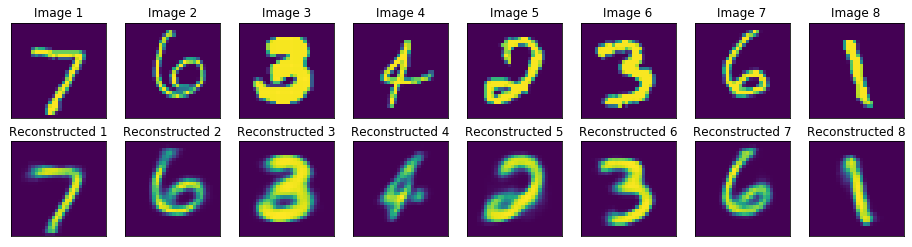

-------------------------------------------------------------------
[epoch 18], [test bce loss 9601.8478 +/- 578.8145], [test kld loss 1539.8519 +/- 49.6696], [testing time 1.86]
-------------------------------------------------------------------


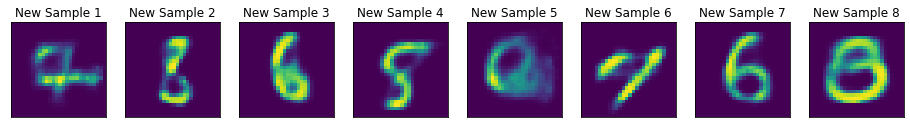

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 19], [train bce loss 9571.2172 +/- 325.4793], [train kld loss 1525.8105 +/- 26.9207], [training time 7.92]
-------------------------------------------------------------------


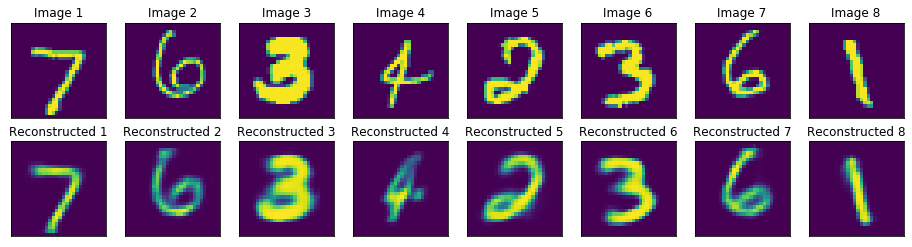

-------------------------------------------------------------------
[epoch 19], [test bce loss 9487.5298 +/- 582.1744], [test kld loss 1572.7082 +/- 48.5634], [testing time 1.61]
-------------------------------------------------------------------


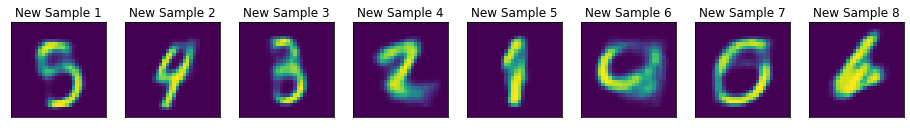

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 20], [train bce loss 9490.8385 +/- 325.8925], [train kld loss 1539.1477 +/- 26.6702], [training time 8.31]
-------------------------------------------------------------------


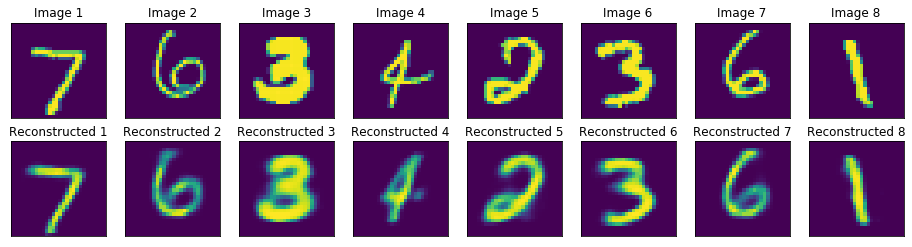

-------------------------------------------------------------------
[epoch 20], [test bce loss 9486.9900 +/- 579.7226], [test kld loss 1529.3043 +/- 49.6254], [testing time 1.99]
-------------------------------------------------------------------


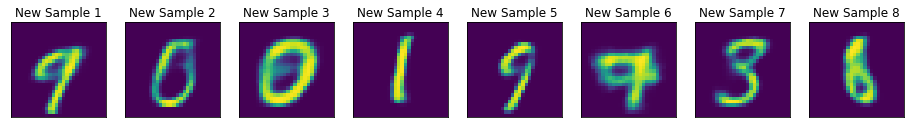

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 21], [train bce loss 9425.5598 +/- 317.2258], [train kld loss 1550.2879 +/- 26.2255], [training time 8.22]
-------------------------------------------------------------------


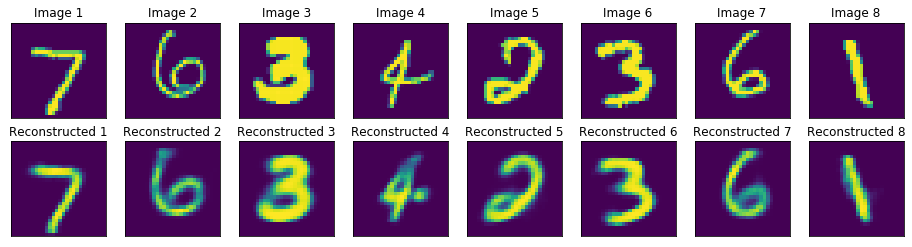

-------------------------------------------------------------------
[epoch 21], [test bce loss 9442.8128 +/- 569.8301], [test kld loss 1515.1377 +/- 40.7171], [testing time 1.60]
-------------------------------------------------------------------


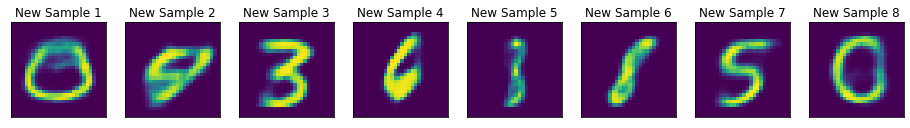

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 22], [train bce loss 9366.3754 +/- 324.3687], [train kld loss 1561.4361 +/- 27.0029], [training time 8.36]
-------------------------------------------------------------------


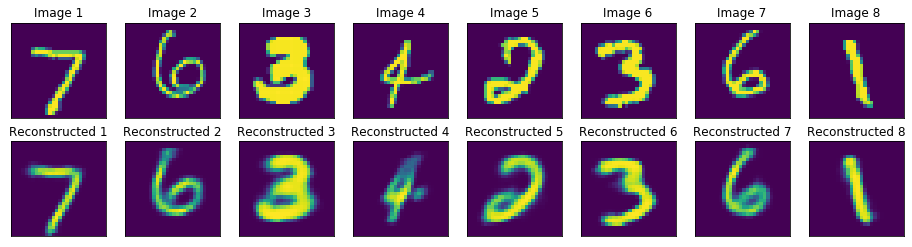

-------------------------------------------------------------------
[epoch 22], [test bce loss 9396.9266 +/- 572.0498], [test kld loss 1546.2416 +/- 46.8210], [testing time 1.71]
-------------------------------------------------------------------


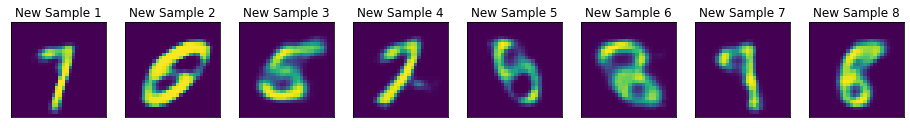

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 23], [train bce loss 9313.9455 +/- 314.6369], [train kld loss 1568.9944 +/- 26.5006], [training time 8.66]
-------------------------------------------------------------------


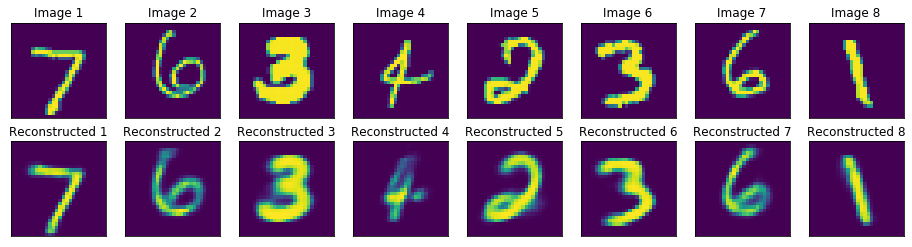

-------------------------------------------------------------------
[epoch 23], [test bce loss 9330.1426 +/- 580.5297], [test kld loss 1547.1272 +/- 41.3082], [testing time 1.68]
-------------------------------------------------------------------


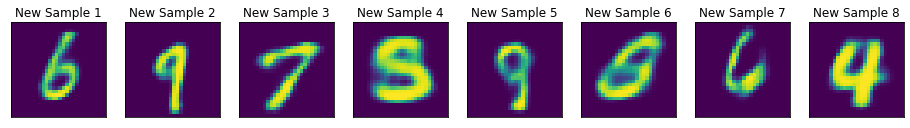

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 24], [train bce loss 9267.4367 +/- 339.0426], [train kld loss 1576.5853 +/- 27.1275], [training time 8.05]
-------------------------------------------------------------------


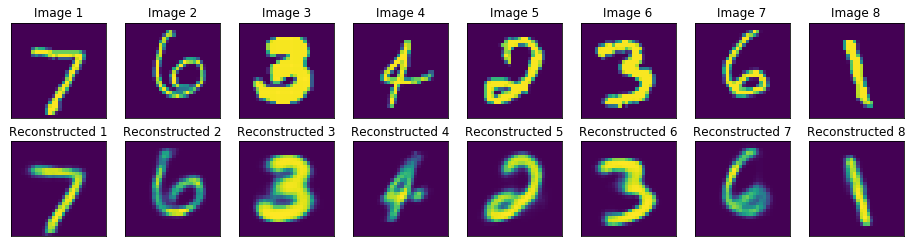

-------------------------------------------------------------------
[epoch 24], [test bce loss 9265.2076 +/- 578.2322], [test kld loss 1583.5753 +/- 39.5882], [testing time 1.77]
-------------------------------------------------------------------


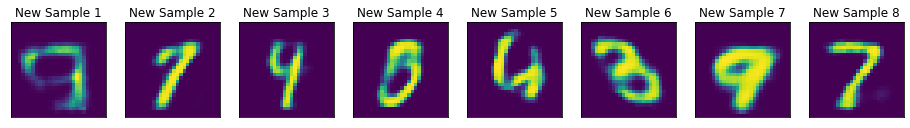

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 25], [train bce loss 9226.2126 +/- 312.3849], [train kld loss 1582.0179 +/- 27.3558], [training time 8.54]
-------------------------------------------------------------------


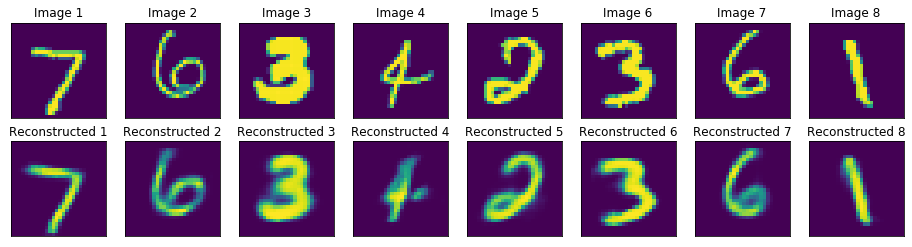

-------------------------------------------------------------------
[epoch 25], [test bce loss 9251.3447 +/- 573.3045], [test kld loss 1568.6296 +/- 38.4997], [testing time 1.93]
-------------------------------------------------------------------


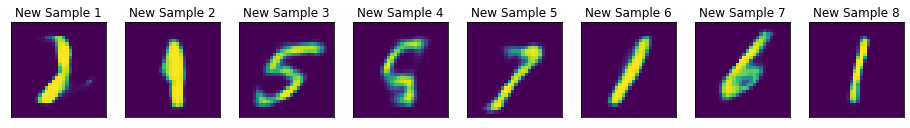

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 26], [train bce loss 9189.5578 +/- 300.3931], [train kld loss 1588.8483 +/- 26.9080], [training time 8.19]
-------------------------------------------------------------------


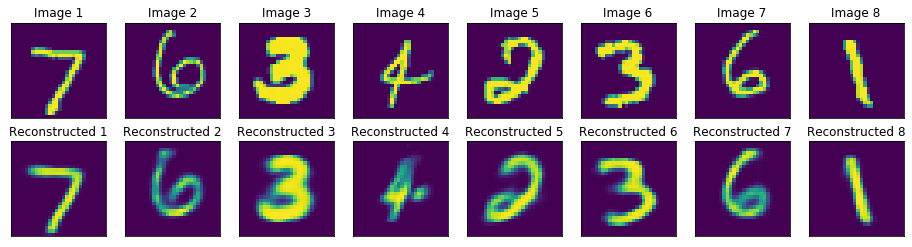

-------------------------------------------------------------------
[epoch 26], [test bce loss 9211.4944 +/- 566.0465], [test kld loss 1610.2874 +/- 45.6350], [testing time 1.68]
-------------------------------------------------------------------


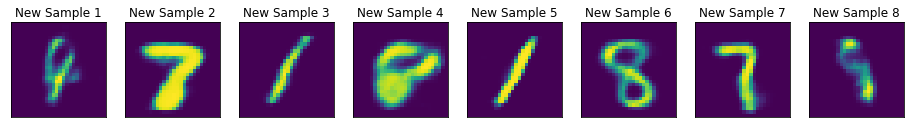

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 27], [train bce loss 9152.0691 +/- 333.4417], [train kld loss 1594.4067 +/- 29.1126], [training time 8.27]
-------------------------------------------------------------------


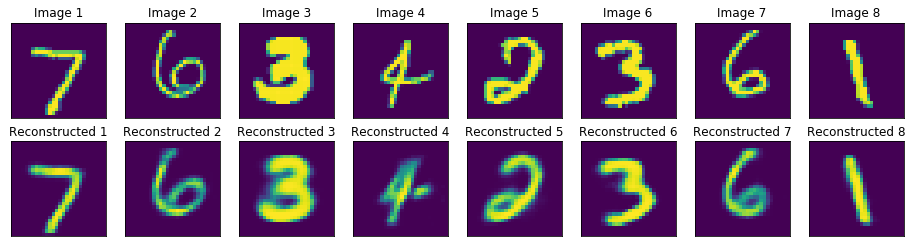

-------------------------------------------------------------------
[epoch 27], [test bce loss 9197.4112 +/- 572.9935], [test kld loss 1599.4138 +/- 41.2437], [testing time 1.89]
-------------------------------------------------------------------


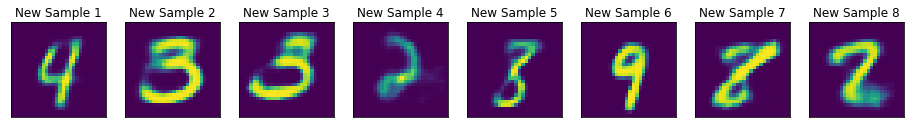

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 28], [train bce loss 9121.1406 +/- 338.2128], [train kld loss 1599.7609 +/- 25.8668], [training time 8.52]
-------------------------------------------------------------------


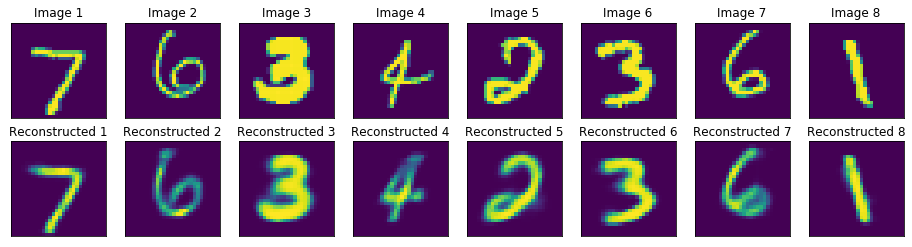

-------------------------------------------------------------------
[epoch 28], [test bce loss 9146.7602 +/- 570.0607], [test kld loss 1623.2558 +/- 45.2209], [testing time 1.67]
-------------------------------------------------------------------


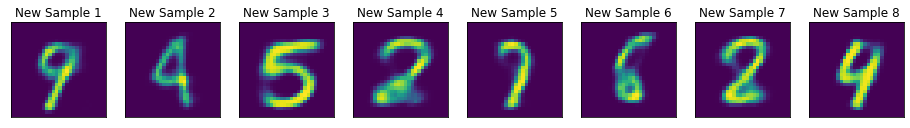

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 29], [train bce loss 9091.0655 +/- 325.1116], [train kld loss 1602.3783 +/- 28.0891], [training time 8.29]
-------------------------------------------------------------------


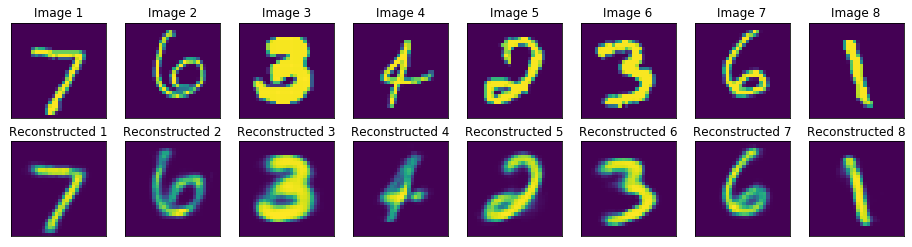

-------------------------------------------------------------------
[epoch 29], [test bce loss 9142.7822 +/- 573.7045], [test kld loss 1595.1050 +/- 42.7605], [testing time 1.79]
-------------------------------------------------------------------


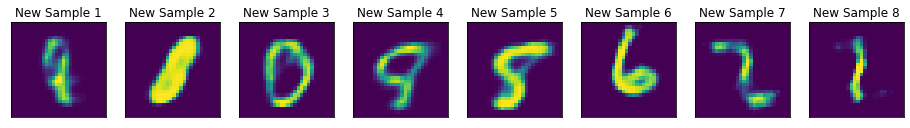

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 30], [train bce loss 9063.5926 +/- 311.2949], [train kld loss 1608.1499 +/- 25.6503], [training time 8.41]
-------------------------------------------------------------------


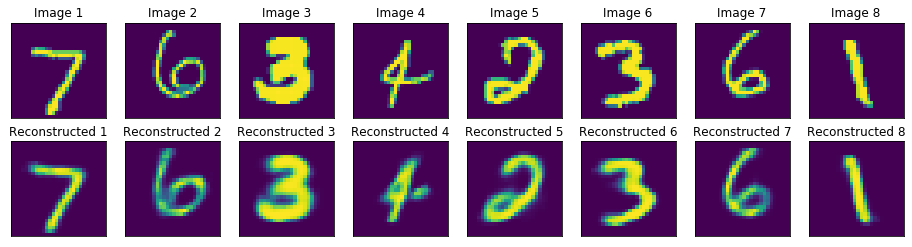

-------------------------------------------------------------------
[epoch 30], [test bce loss 9078.3788 +/- 572.2897], [test kld loss 1637.9448 +/- 45.3070], [testing time 1.75]
-------------------------------------------------------------------


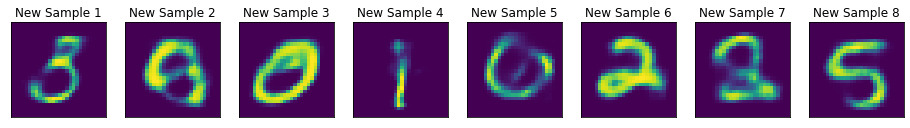

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 31], [train bce loss 9034.2969 +/- 297.0967], [train kld loss 1610.0642 +/- 27.5623], [training time 8.16]
-------------------------------------------------------------------


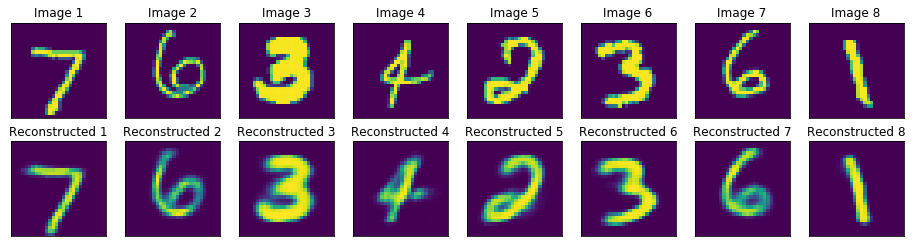

-------------------------------------------------------------------
[epoch 31], [test bce loss 9096.7436 +/- 567.7163], [test kld loss 1624.0840 +/- 46.6711], [testing time 1.89]
-------------------------------------------------------------------


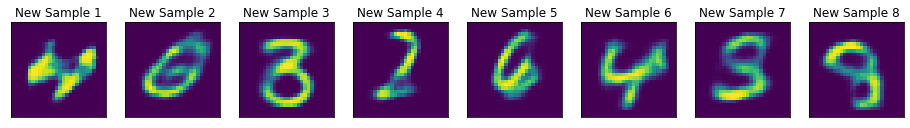

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 32], [train bce loss 9012.8560 +/- 312.5218], [train kld loss 1614.2820 +/- 30.8456], [training time 8.53]
-------------------------------------------------------------------


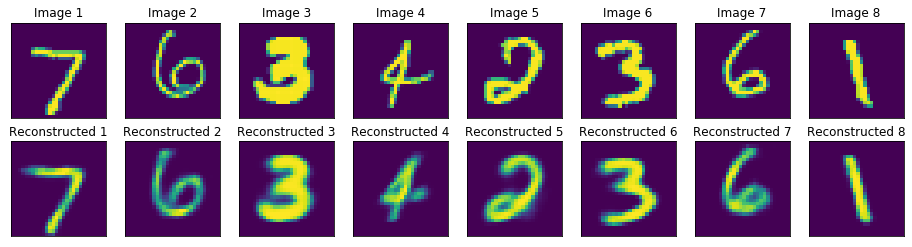

-------------------------------------------------------------------
[epoch 32], [test bce loss 9076.1674 +/- 566.6970], [test kld loss 1606.1053 +/- 43.5837], [testing time 1.83]
-------------------------------------------------------------------


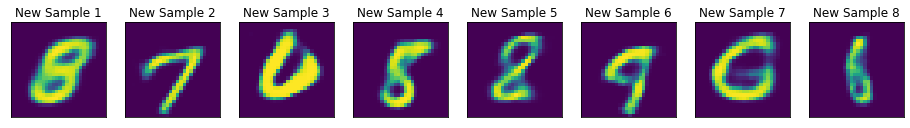

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 33], [train bce loss 8983.5970 +/- 309.9151], [train kld loss 1621.2031 +/- 27.0603], [training time 8.13]
-------------------------------------------------------------------


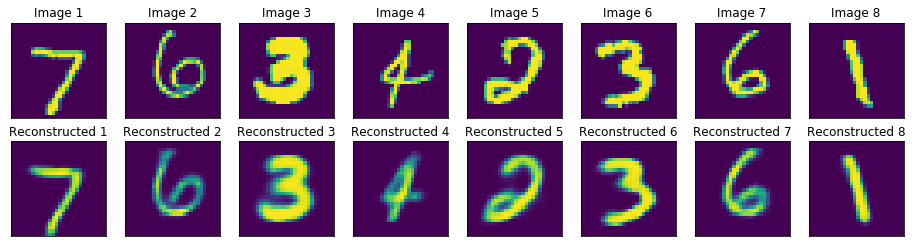

-------------------------------------------------------------------
[epoch 33], [test bce loss 9040.3034 +/- 571.6762], [test kld loss 1635.7720 +/- 39.1343], [testing time 1.74]
-------------------------------------------------------------------


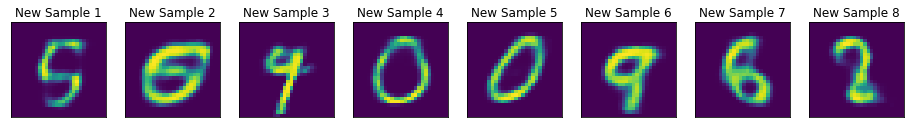

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 34], [train bce loss 8954.4354 +/- 293.9104], [train kld loss 1627.8356 +/- 28.4063], [training time 8.50]
-------------------------------------------------------------------


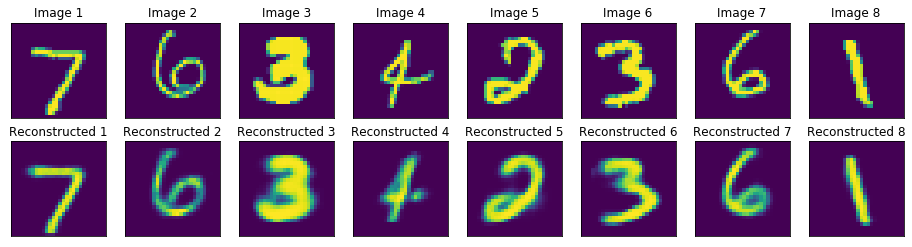

-------------------------------------------------------------------
[epoch 34], [test bce loss 9009.9673 +/- 560.5157], [test kld loss 1653.5889 +/- 47.1243], [testing time 1.72]
-------------------------------------------------------------------


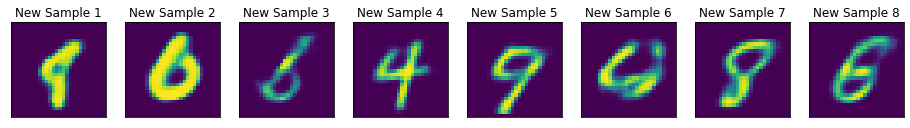

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 35], [train bce loss 8919.7009 +/- 319.2967], [train kld loss 1637.8526 +/- 29.4040], [training time 8.35]
-------------------------------------------------------------------


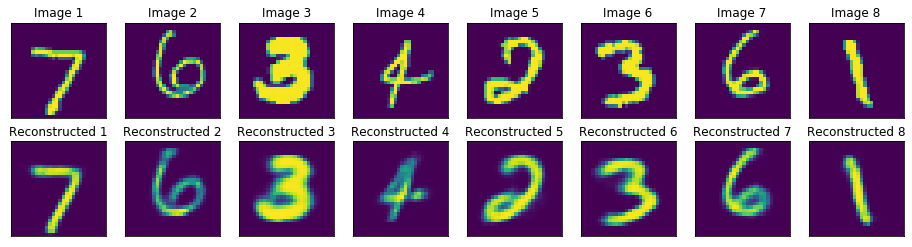

-------------------------------------------------------------------
[epoch 35], [test bce loss 8981.3737 +/- 560.6709], [test kld loss 1672.7710 +/- 46.8750], [testing time 1.72]
-------------------------------------------------------------------


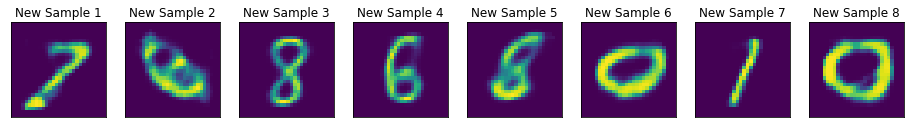

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 36], [train bce loss 8890.1760 +/- 315.3935], [train kld loss 1646.0310 +/- 26.8080], [training time 8.25]
-------------------------------------------------------------------


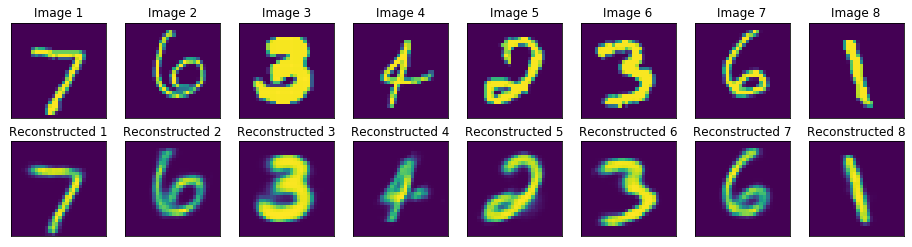

-------------------------------------------------------------------
[epoch 36], [test bce loss 8942.4804 +/- 558.5485], [test kld loss 1678.5977 +/- 44.2377], [testing time 1.75]
-------------------------------------------------------------------


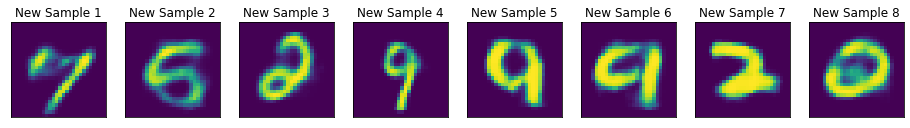

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 37], [train bce loss 8855.1031 +/- 292.6707], [train kld loss 1655.0964 +/- 28.6417], [training time 8.65]
-------------------------------------------------------------------


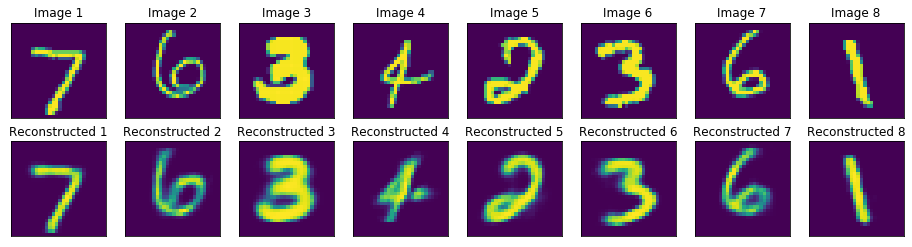

-------------------------------------------------------------------
[epoch 37], [test bce loss 8918.5218 +/- 563.7884], [test kld loss 1669.4515 +/- 45.1883], [testing time 1.77]
-------------------------------------------------------------------


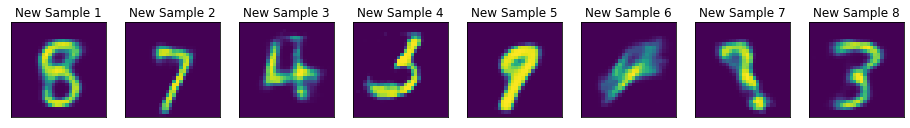

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 38], [train bce loss 8819.1853 +/- 300.7217], [train kld loss 1664.9936 +/- 27.0726], [training time 8.49]
-------------------------------------------------------------------


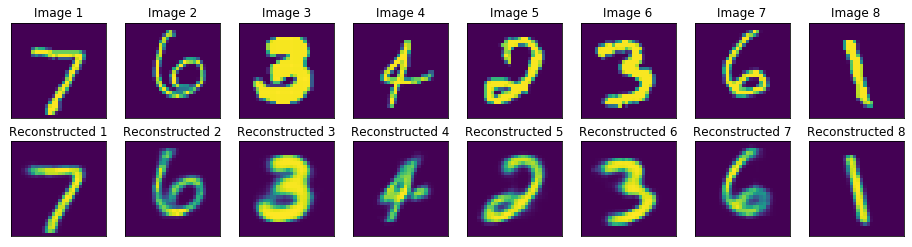

-------------------------------------------------------------------
[epoch 38], [test bce loss 8892.7914 +/- 566.9023], [test kld loss 1684.5903 +/- 46.2071], [testing time 1.85]
-------------------------------------------------------------------


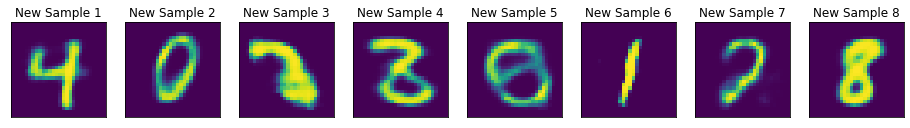

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 39], [train bce loss 8791.6380 +/- 296.7306], [train kld loss 1672.8805 +/- 27.9835], [training time 8.00]
-------------------------------------------------------------------


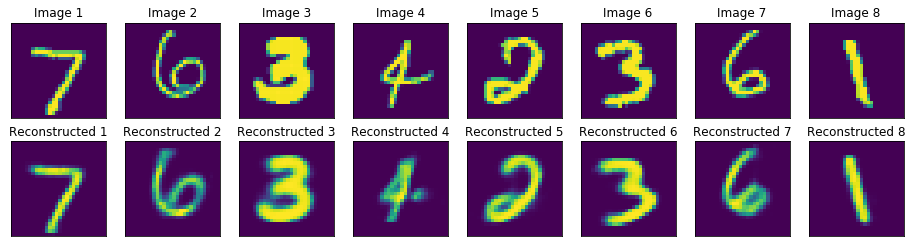

-------------------------------------------------------------------
[epoch 39], [test bce loss 8872.7852 +/- 557.1177], [test kld loss 1672.8534 +/- 48.1124], [testing time 1.69]
-------------------------------------------------------------------


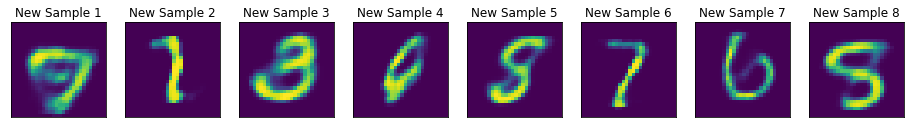

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 40], [train bce loss 8762.7712 +/- 296.6522], [train kld loss 1680.1090 +/- 28.6972], [training time 8.50]
-------------------------------------------------------------------


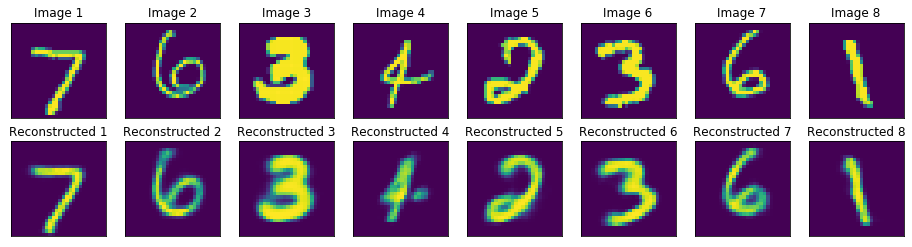

-------------------------------------------------------------------
[epoch 40], [test bce loss 8819.3147 +/- 540.1840], [test kld loss 1699.4835 +/- 48.7663], [testing time 1.88]
-------------------------------------------------------------------


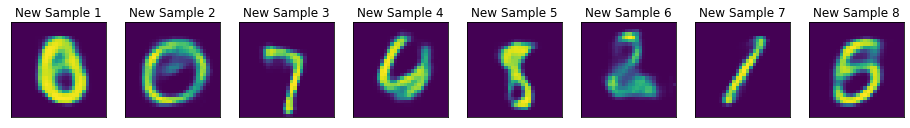

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 41], [train bce loss 8735.9166 +/- 297.9747], [train kld loss 1685.8705 +/- 29.0207], [training time 8.35]
-------------------------------------------------------------------


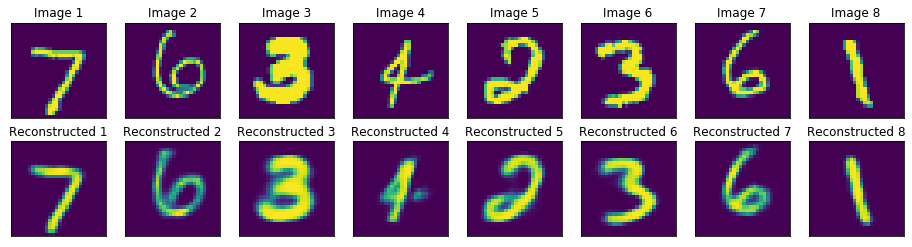

-------------------------------------------------------------------
[epoch 41], [test bce loss 8855.1853 +/- 549.2816], [test kld loss 1669.1085 +/- 45.3849], [testing time 1.73]
-------------------------------------------------------------------


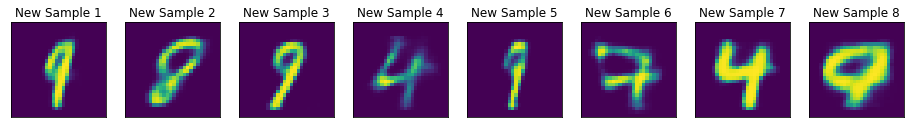

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 42], [train bce loss 8708.9141 +/- 280.9763], [train kld loss 1691.2909 +/- 28.0499], [training time 8.71]
-------------------------------------------------------------------


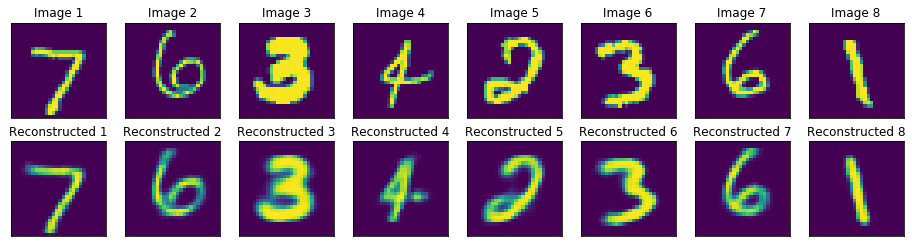

-------------------------------------------------------------------
[epoch 42], [test bce loss 8800.1415 +/- 541.1354], [test kld loss 1697.1344 +/- 48.9885], [testing time 1.89]
-------------------------------------------------------------------


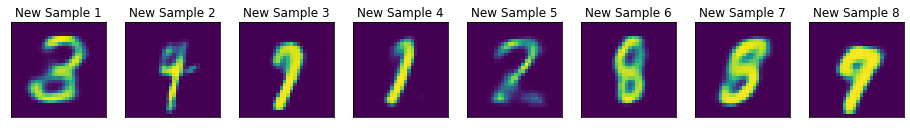

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 43], [train bce loss 8687.1364 +/- 292.3995], [train kld loss 1699.4496 +/- 28.7132], [training time 8.27]
-------------------------------------------------------------------


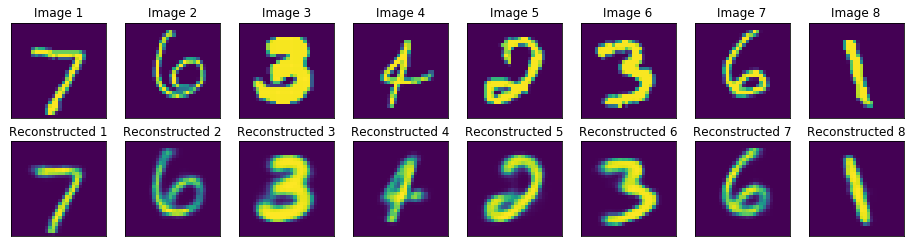

-------------------------------------------------------------------
[epoch 43], [test bce loss 8756.5450 +/- 544.3273], [test kld loss 1722.9434 +/- 49.2006], [testing time 1.67]
-------------------------------------------------------------------


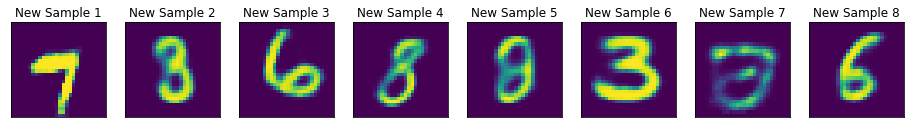

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 44], [train bce loss 8665.5253 +/- 293.3989], [train kld loss 1702.6478 +/- 28.8984], [training time 7.99]
-------------------------------------------------------------------


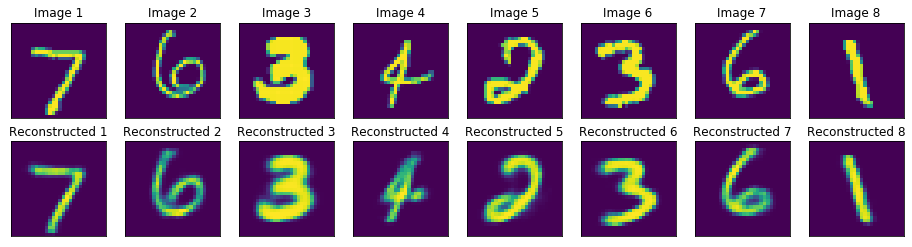

-------------------------------------------------------------------
[epoch 44], [test bce loss 8769.5003 +/- 543.4197], [test kld loss 1694.5541 +/- 43.1919], [testing time 1.66]
-------------------------------------------------------------------


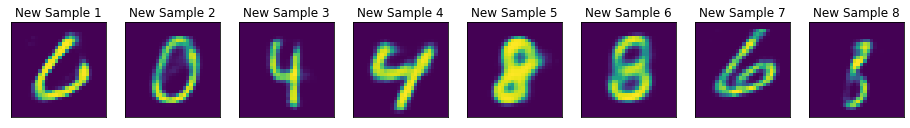

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 45], [train bce loss 8643.9154 +/- 295.3987], [train kld loss 1707.9352 +/- 30.9886], [training time 7.90]
-------------------------------------------------------------------


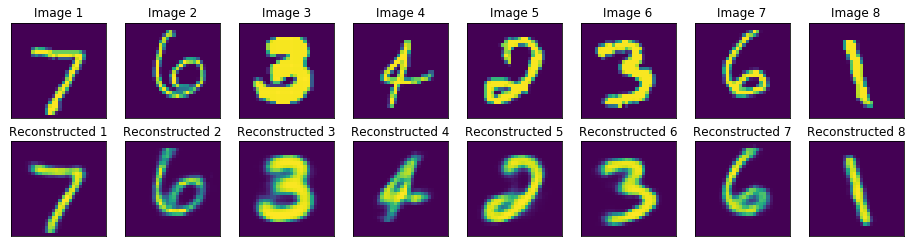

-------------------------------------------------------------------
[epoch 45], [test bce loss 8767.8620 +/- 548.0047], [test kld loss 1696.2106 +/- 50.2305], [testing time 1.72]
-------------------------------------------------------------------


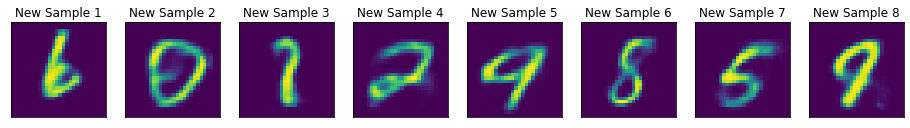

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 46], [train bce loss 8623.1990 +/- 284.3579], [train kld loss 1709.6470 +/- 28.5429], [training time 8.01]
-------------------------------------------------------------------


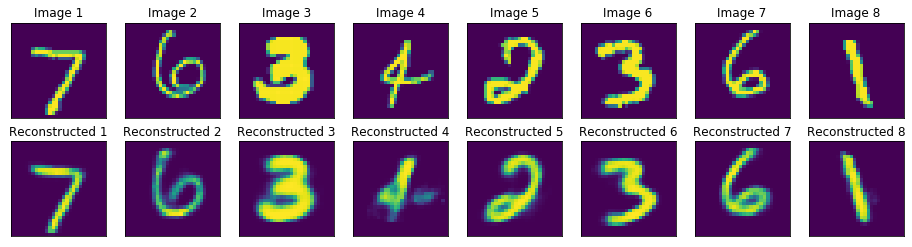

-------------------------------------------------------------------
[epoch 46], [test bce loss 8753.8196 +/- 539.4659], [test kld loss 1688.8113 +/- 44.9106], [testing time 1.74]
-------------------------------------------------------------------


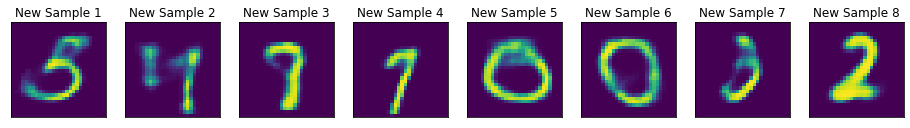

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 47], [train bce loss 8605.7066 +/- 304.3008], [train kld loss 1717.6512 +/- 28.9320], [training time 7.55]
-------------------------------------------------------------------


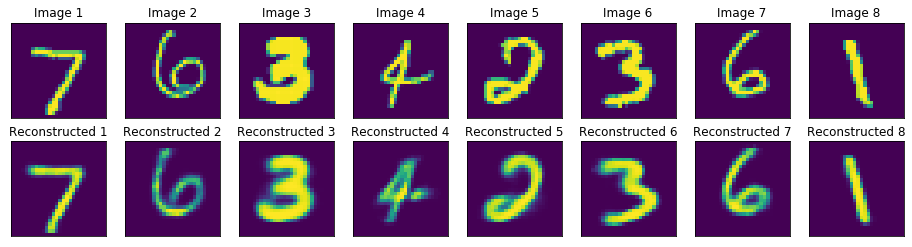

-------------------------------------------------------------------
[epoch 47], [test bce loss 8704.2326 +/- 545.3242], [test kld loss 1728.7420 +/- 44.1231], [testing time 1.84]
-------------------------------------------------------------------


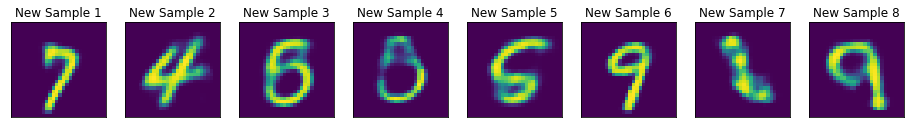

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 48], [train bce loss 8585.3278 +/- 286.1781], [train kld loss 1720.5952 +/- 30.6359], [training time 8.04]
-------------------------------------------------------------------


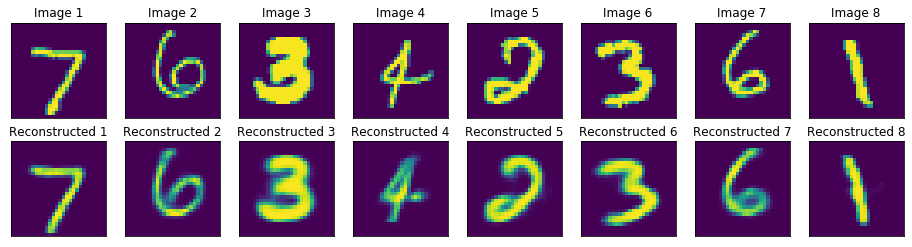

-------------------------------------------------------------------
[epoch 48], [test bce loss 8712.1336 +/- 544.0763], [test kld loss 1714.7339 +/- 46.2040], [testing time 1.63]
-------------------------------------------------------------------


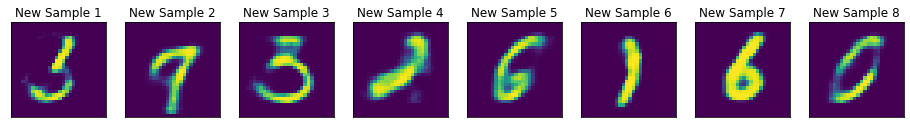

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 49], [train bce loss 8571.2727 +/- 281.8016], [train kld loss 1723.8866 +/- 34.2971], [training time 8.21]
-------------------------------------------------------------------


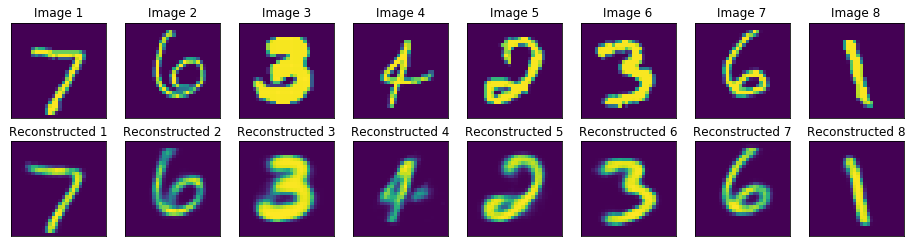

-------------------------------------------------------------------
[epoch 49], [test bce loss 8703.8818 +/- 535.6274], [test kld loss 1726.3411 +/- 45.2740], [testing time 1.66]
-------------------------------------------------------------------


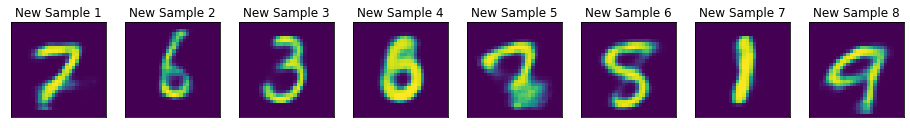

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 50], [train bce loss 8555.2314 +/- 292.2146], [train kld loss 1726.3741 +/- 31.0458], [training time 7.76]
-------------------------------------------------------------------


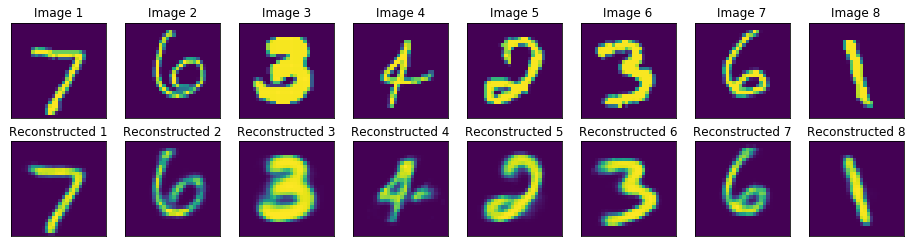

-------------------------------------------------------------------
[epoch 50], [test bce loss 8702.3956 +/- 537.8035], [test kld loss 1702.7843 +/- 43.9291], [testing time 1.68]
-------------------------------------------------------------------


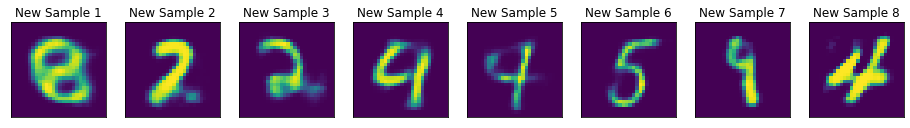

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------


In [10]:
# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train(train_loader, net, optimizer, epoch)

    # Computing test loss and metrics.
    test(test_loader, net, epoch)
    
    # Evaluating sample generation in VAE.
    evaluate(net, args['num_samples'], args['num_gauss'])
    
    print('-- End of Epoch ---------------------------------------------------')
    print('-------------------------------------------------------------------')

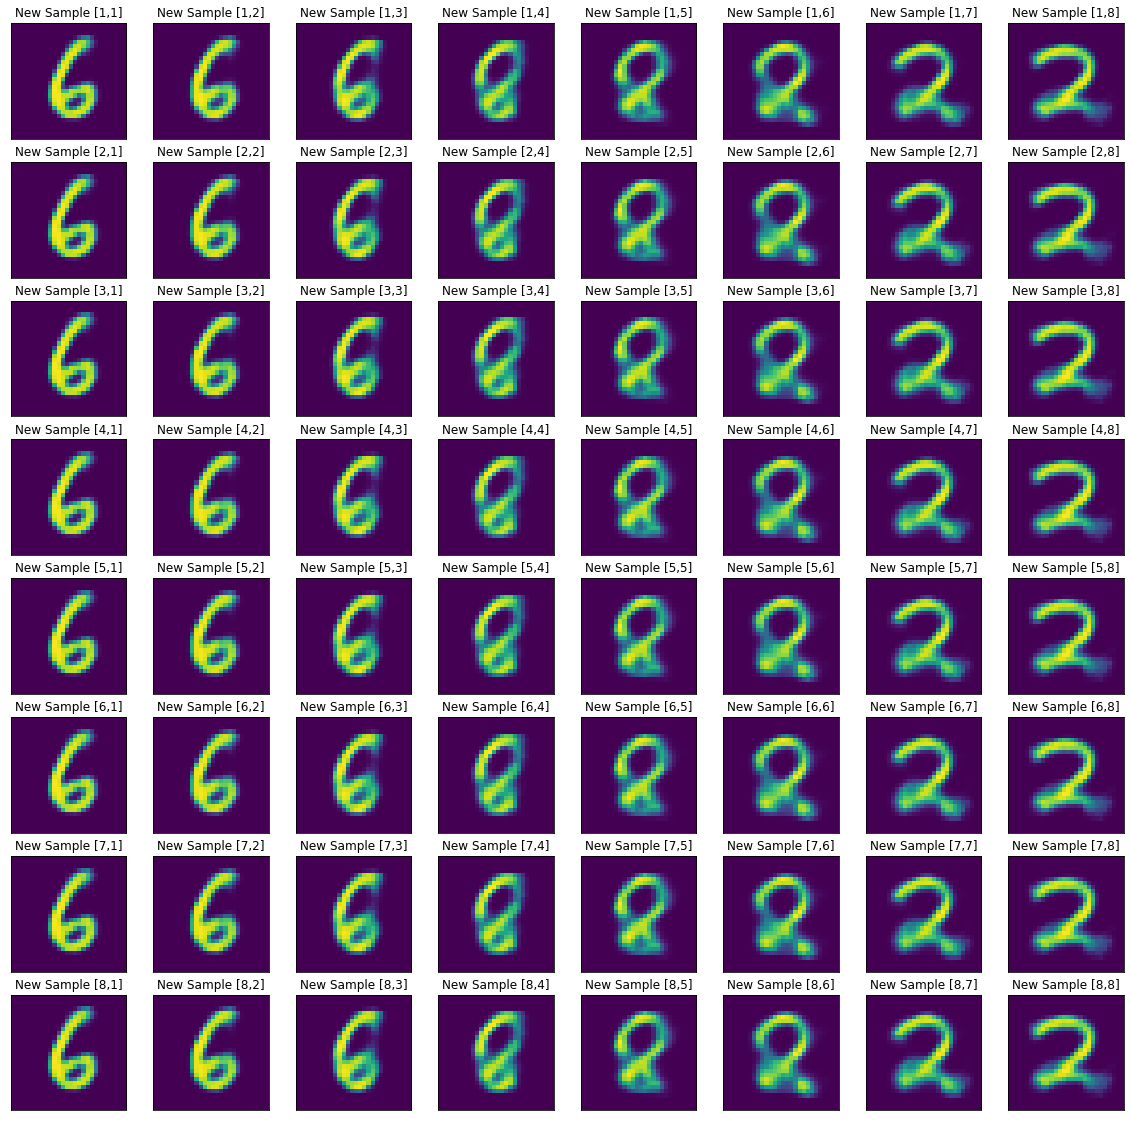

In [11]:
# Evaluation procedure for sample generation.
def generate_2d(net, n_samples, n_gauss):

    # Setting network for evaluation mode.
    net.eval()
    
    # Creating linear space to visualize bivariate gaussian.
    linspace_gauss = torch.linspace(-2.5, 2.5, n_samples)
    
    # Select Gaussian dimensions
    dim_linspace = (0, 1)
    
    # Plotting.
    fig, ax = plt.subplots(n_samples, n_samples, figsize=(20, 20))

    for i in range(n_samples):
        
        for j in range(n_samples):

            # Filling batch with size 1 and n_gauss zeros of dimension.
            sample = torch.zeros(1, n_gauss).to(args['device'])
            
            # Replacing zeros in dimensions dim_linspace with values from
            # variable linspace_gauss.
            sample[0, dim_linspace[0]] = linspace_gauss[j]
            sample[0, dim_linspace[1]] = linspace_gauss[i]

            # Forwarding through decoder.
            sample = net.decode(sample).detach().cpu().view(28, 28).numpy()

            # Printing sample.
            ax[j, i].imshow(sample)
            ax[j, i].set_yticks([])
            ax[j, i].set_xticks([])
            ax[j, i].set_title('New Sample [' + str(j + 1) + ',' + str(i + 1) + ']')
        
    plt.show()
    
    
generate_2d(net, args['num_samples'], args['num_gauss'])